<a href="https://colab.research.google.com/github/timothy-hister/pneumonia/blob/main/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

According to the World Health Organization, pneumonia killed more than 808,000 children under the age of five in 2017. An accurate and timely diagnosis of the disease could be the difference in saving many lives.   Researchers from the University of California, San Diego, have created a dataset containing 5856 chest X-ray images from children, split between a training dataset and a test dataset. Each image has a label that specifies if the X-ray corresponds to a patient with pneumonia or one without it. In this project, we will build a some deep learning models trained on these images that attempt to classify whether an X-ray indicates signs of pneumonia.

# Load Datasets

In [1]:
# Imports

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, Model, Input, applications, initializers
from keras.callbacks import History
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tarfile

# Misc Objects
nns = {} # where to store results

# Parameters (hopefully these all make sense)
img_size = 256
scale_amt = 1/255
batch_size = 128
validation_split = 0.2
learning_rate = .001
epochs = 20
patience = 3 # callback stopping parameter

# Functions

# plot the loss and accuracy metrics by epoch number for a model
def plot_epochs():
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_title('Accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'val'], loc='upper left')

  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('Loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'val'], loc='upper right')

  plt.show()

# store results of a model in the dictionary `nns`
def store_results():
  d = {}
  d['model'] = model
  d['history'] = history
  return d

In [2]:
# Get and extract the data set

!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

extract_tar_gz('xray_dataset.tar.gz', '.')

--2023-07-31 15:29:50--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.216.63.57, 52.217.110.204, 52.216.206.147, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.216.63.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  45.1MB/s    in 26s     

2023-07-31 15:30:17 (44.2 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



In [3]:
# Create the three data sets and scale them

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    validation_split=validation_split,
    subset="training",
    seed=417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    validation_split=validation_split,
    subset="validation",
    seed=417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(img_size, img_size))

normalization_layer = layers.Rescaling(scale_amt)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


# Data Exploration

In [4]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [5]:
# Get a batch of data to examine

train_set_element = train_set.take(1)
for images, labels in train_set_element:
    images = images.numpy()
    labels = labels.numpy()

Let's compare a pneumonia image with a 'normal' image.

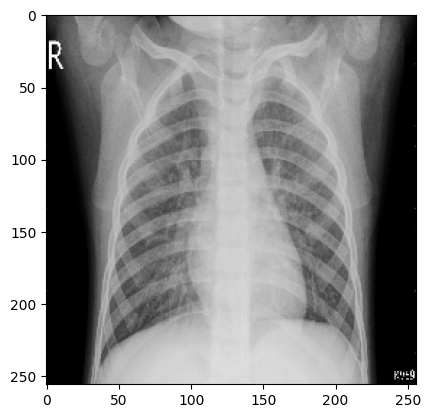

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [6]:
idx = 0
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

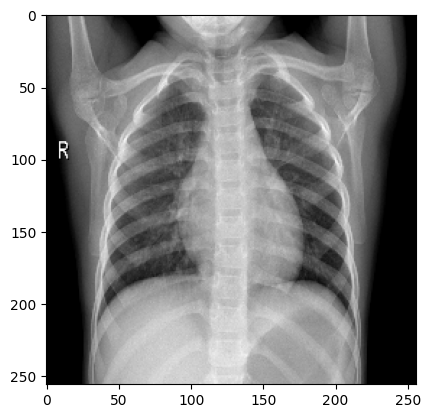

Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)


In [7]:
idx = 1
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

I certainly can't tell the difference! Also, the lungs and ribs are all going to be identical in all cases, meaning that a very complex model will likely be required. Other things to note: The X-rays are not centered and The images are all rotated at different angles. Presumably, we can use random rotations effectively. Finally, even though the images look to be in greyscale, they have 3 color channels.

# Simple CNN

This is the first model that features convolutional, max pool, flatten and dense layers. We'll train for a maximum of 10 epochs (with the stopping early callback based on the validation loss).

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 16)                1016080   
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,016,562
Trainable params: 1,016,562
Non-trainable params: 0
______________________________________________

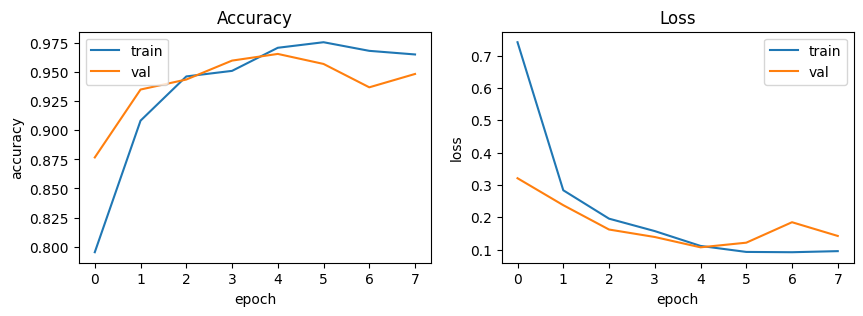

In [8]:
model_name = 'cnn1'
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.build(input_shape=(None, img_size, img_size, 3))
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = model.fit(train_set_normalized, epochs=epochs, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

nns[model_name] = store_results()
plot_epochs()

This is pretty good accuracy for a first pass at this. Note that we stopped after 7 epochs, meaning that the validation loss didn't fall for three straight epochs. There is evidence of overfitting, so we will try some regularization in the next version.

# Simple CNN with Regularization

This model builds on the previous one by the addition of data augmentation layers (random flips, etc.), different filter numbers, sizes, strides, and number of convolutional layers, more fully-connected layers with different number of units, and replacing batch normalization layers with dropout layers.


Epoch 1/20
33/33 [==============================] - 41s 876ms/step - loss: 0.6861 - accuracy: 0.7045 - val_loss: 0.5904 - val_accuracy: 0.7629
Epoch 2/20
33/33 [==============================] - 34s 828ms/step - loss: 0.6024 - accuracy: 0.7348 - val_loss: 0.4590 - val_accuracy: 0.7629
Epoch 3/20
33/33 [==============================] - 33s 837ms/step - loss: 0.4973 - accuracy: 0.7398 - val_loss: 0.3523 - val_accuracy: 0.7629
Epoch 4/20
33/33 [==============================] - 34s 833ms/step - loss: 0.4024 - accuracy: 0.7886 - val_loss: 0.2661 - val_accuracy: 0.9034
Epoch 5/20
33/33 [==============================] - 34s 861ms/step - loss: 0.3390 - accuracy: 0.8476 - val_loss: 0.5148 - val_accuracy: 0.6415
Epoch 6/20
33/33 [==============================] - 34s 840ms/step - loss: 0.3293 - accuracy: 0.8641 - val_loss: 0.2182 - val_accuracy: 0.9092
Epoch 7/20
33/33 [==============================] - 38s 989ms/step - loss: 0.3113 - accuracy: 0.8741 - val_loss: 0.2266 - val_accuracy: 0.8939

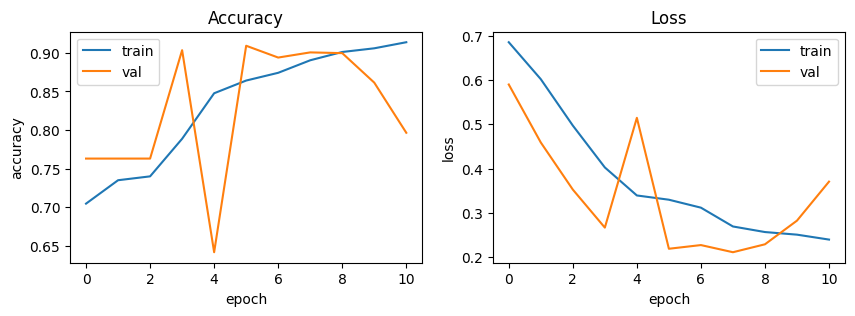

In [9]:
model_name = 'cnn2'
model = models.Sequential()
model.add(layers.RandomZoom(height_factor=0.1))
model.add(layers.RandomRotation(factor=0.2))
model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))
model.add(layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
model.build((None, img_size, img_size, 3))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = model.fit(train_set_normalized, epochs=epochs, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

nns[model_name] = store_results()
plot_epochs()

I can't quite explain why the accuracy and loss curves go haywire on the fourth epoch, as well as why the model fit gets substantially worse toward the end. Note, as before, the model stops after 10 epochs of training.

# Transfer Learning Model

In this model, we use parameters trained for the ResNet V2 model. ResNet was not trained on radiology images, so there might not be great fit, particularly in early epochs. For the first model, we will freeze all parameters from the original ResNet model and then add features, such as global average pooling and fully connected layers at the end.

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                      

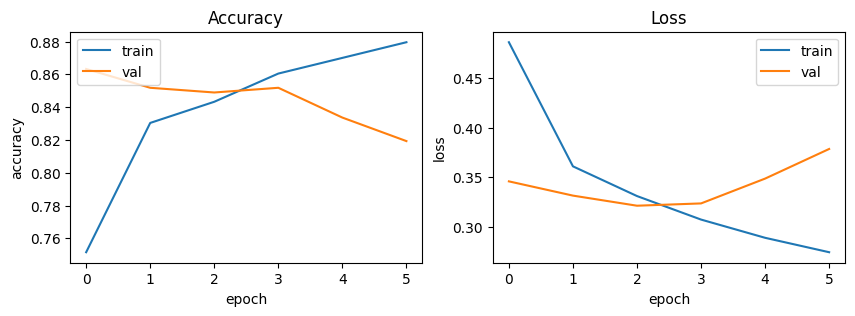

In [10]:
model_name = 'tl1'

# Set up the Resnet V2 model and freeze the parameters (so they won't be trained by the current model)

base_model = applications.resnet_v2.ResNet50V2(
  include_top=False,
  weights='imagenet',
  input_shape=(img_size, img_size, 3)
)

# Freeze parameters
base_model.trainable = False

# Preprocess inputs
input_layer = Input(shape=(img_size, img_size, 3))
preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)

# Build model
X = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
X = layers.RandomRotation(factor=0.2)(X)
X = base_model(X, training=False)

X = layers.GlobalAveragePooling2D()(X)
X = layers.Dense(512, activation='relu')(X)
X = layers.Dense(128, activation='relu')(X)
X = layers.Dense(32, activation='relu')(X)
output_layer = layers.Dense(2, activation='softmax')(X)
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = model.fit(train_set_normalized, epochs=epochs, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

nns[model_name] = store_results()
plot_epochs()

It appears that the model fit gets worse on the validation set as parameters get trained. This does not instill confidence that ResNet is a good base model for radiology classification.

# Transfer Learning with Training

In this model, we'll unfreeze the last ten layers so that the model can learn parameters from the data instead of relying entirely on Resnet parameters. Everything else is the same as the previous model.

Epoch 1/20
33/33 [==============================] - 49s 1s/step - loss: 1.7297 - accuracy: 0.7040 - val_loss: 0.5409 - val_accuracy: 0.7629
Epoch 2/20
33/33 [==============================] - 40s 1s/step - loss: 0.5572 - accuracy: 0.7358 - val_loss: 0.4938 - val_accuracy: 0.7629
Epoch 3/20
33/33 [==============================] - 41s 1s/step - loss: 0.4626 - accuracy: 0.7869 - val_loss: 0.3706 - val_accuracy: 0.8098
Epoch 4/20
33/33 [==============================] - 40s 1s/step - loss: 0.3893 - accuracy: 0.8170 - val_loss: 0.3322 - val_accuracy: 0.8442
Epoch 5/20
33/33 [==============================] - 39s 988ms/step - loss: 0.3522 - accuracy: 0.8278 - val_loss: 0.3285 - val_accuracy: 0.8413
Epoch 6/20
33/33 [==============================] - 41s 1s/step - loss: 0.3275 - accuracy: 0.8495 - val_loss: 0.2957 - val_accuracy: 0.8681
Epoch 7/20
33/33 [==============================] - 40s 1s/step - loss: 0.3096 - accuracy: 0.8555 - val_loss: 0.3715 - val_accuracy: 0.8088
Epoch 8/20
33/33 

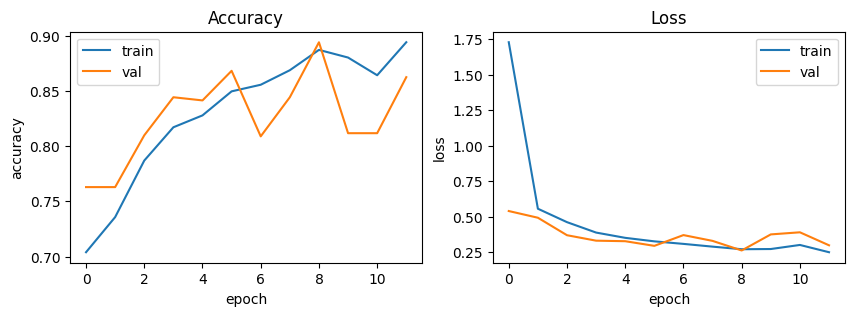

In [11]:
model_name = 'tl2'

# Unfreeze the last ten layers of the base model only
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable=False

# Everything else remains the same from the previous `tl1` model
model = nns['tl1']['model']
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = model.fit(train_set_normalized, epochs=epochs, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

nns[model_name] = store_results()
plot_epochs()

Now, we can see some evidence of over-fitting. Also, the fit on the validation set jumps around across epochs.

# Conclusion

In conclusion, we evaluate all four models on the test set and compare loss and accuracy.

In [12]:
for nn in nns:
  test_loss, test_acc = nns[nn]['model'].evaluate(test_set_normalized, verbose=False)
  print(f"{nn}: Test Loss = {round(test_loss, 2)}; Test Accuracy = {round(test_acc, 2)}")

cnn1: Test Loss = 0.61; Test Accuracy = 0.76
cnn2: Test Loss = 0.3; Test Accuracy = 0.89
tl1: Test Loss = 0.39; Test Accuracy = 0.85
tl2: Test Loss = 0.39; Test Accuracy = 0.85


The transfer learning models do equally well as one another, and do not do better than the convolutional model with regularization. The overall conclusion is that more work will be needed if either convolutional models or transfer learning models using ResNet V2 can be used to predict pneumonia status using radiology images.